In [1]:
import pandas as pd 
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import re
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.sequence import pad_sequences

In [2]:
df = pd.read_csv('English Sarcasm - English Sarcasm.csv')
df.head()

,Tweet,Label
0,I love finding out who your true friends are. ...,0
1,USER :/ bye,0
2,USER I absolutely love Kanye's voice USER,0
3,We're hiring a new Kiosk Supervisor! Think you...,0
4,Every time I see Dave Grohl with his long hipp...,0


In [3]:
df['Label'].value_counts() # class imbalance 

0    3553
1    1000
Name: Label, dtype: int64

In [4]:
#rectiing class imbalance 
class_2,class_1 = df.Label.value_counts()
c2 = df[df['Label'] == 0]
c1 = df[df['Label'] == 1]
df_3 = c1.sample(class_1)
df_2 = c2.sample(class_1)

In [5]:
undersampled_df = pd.concat([df_3,df_2],axis=0)

In [6]:
undersampled_df.Label.value_counts()

0    1000
1    1000
Name: Label, dtype: int64

In [7]:
df = undersampled_df

In [8]:
df.isnull().sum()

Tweet    0
Label    0
dtype: int64

In [9]:
df.dtypes

Tweet    object
Label     int64
dtype: object

In [10]:
# preprocessing data (Cleaning)
df['Tweet'].apply(lambda x: x.lower())
df['Tweet'] = df['Tweet'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))
df['Tweet'].head()

3624                 i love being ignored its my favorite
3630                       love love loooove slow replies
4235    i love being sick makes my mondays even better...
4343    i just love being able to feel my bestfriend a...
4301        i love sitting next to couples in the theater
Name: Tweet, dtype: object

In [11]:
tokenizer = Tokenizer(num_words=5000, split=" ")

In [12]:
tokenizer.fit_on_texts(df['Tweet'].values)

In [13]:
X = tokenizer.texts_to_sequences(df['Tweet'].values)
y = pd.get_dummies(df['Label']).values

In [14]:
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    1,    2,    3,   17,
          25,    7,   92],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    2,    2,
        1432,  438,  679],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    1,    2,    3,   44,   75,    7, 1433,
         108,  228,  538],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           1,    6,    2,    3,  172,    4,   85,    7,  680,    8,    1,
        1434,  681,  539],
    

In [15]:
#defining a LSTM model 
model = Sequential()
model.add(Embedding(5000, 256, input_length=X.shape[1]))
model.add(Dropout(0.5))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(Dropout(0.5))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [16]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 36, 256)           1280000   
_________________________________________________________________
dropout (Dropout)            (None, 36, 256)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 36, 256)           525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 5

In [17]:
y = pd.get_dummies(df['Label']).values

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [19]:
batch_size = 64
epochs = 5

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_test,y_test))

Epoch 1/5
25/25 [==============================] - 29s 407ms/step - loss: 0.6648 - accuracy: 0.5861 - val_loss: 0.4039 - val_accuracy: 0.8400
Epoch 2/5
25/25 [==============================] - 8s 334ms/step - loss: 0.3509 - accuracy: 0.8623 - val_loss: 0.3037 - val_accuracy: 0.8675
Epoch 3/5
25/25 [==============================] - 8s 330ms/step - loss: 0.2312 - accuracy: 0.9057 - val_loss: 0.2749 - val_accuracy: 0.8925
Epoch 4/5
25/25 [==============================] - 9s 350ms/step - loss: 0.1551 - accuracy: 0.9424 - val_loss: 0.2862 - val_accuracy: 0.9000
Epoch 5/5
25/25 [==============================] - 9s 362ms/step - loss: 0.0977 - accuracy: 0.9634 - val_loss: 0.3290 - val_accuracy: 0.8750


In [20]:
def plot_graph(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' +metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

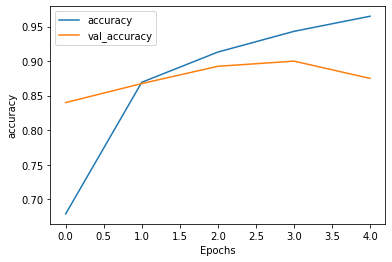

In [21]:
plot_graph(history,'accuracy')

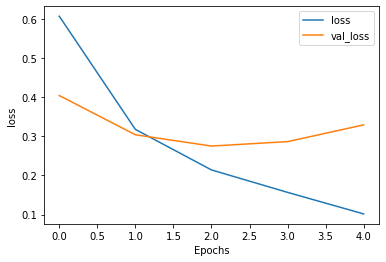

In [22]:
plot_graph(history,'loss')

In [23]:
model.save('Sarcasm_model.h5')

In [24]:
# Confusion Matrix

In [41]:
pred = model.predict(X_test)

In [42]:
from sklearn.metrics import confusion_matrix, classification_report
matrix = confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1))

In [43]:
matrix

array([[168,  32],
       [ 18, 182]])

In [44]:
np.argmax(pred[2])

1

In [45]:
pred = np.argmax(pred, axis=1)
y_test = np.argmax(y_test, axis=1)

In [46]:
target_names = ['Not Sarcasm', 'Sarcasm']
report = classification_report(y_test, pred, target_names=target_names)

In [48]:
print(report)

              precision    recall  f1-score   support

 Not Sarcasm       0.90      0.84      0.87       200
     Sarcasm       0.85      0.91      0.88       200

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.87       400
weighted avg       0.88      0.88      0.87       400

